# NGFS Clean & Interp

### 01/29/24, Erica Simon
## Purpose: prepare IAM projections of future emissions under different policy scenarios
Datasets need to be:
- Appropriate format for harmonization
- Interpolated to annual intervals (rather than 5 year timesteps)
- Infilled for missing species to contain all necessary forcing agents required by FaIR


### Data Source
Data is downloaded from the NGFS cimate scenarios portal for three IAMs (GCAM, MESSAGE, and REMIND). As of March 2024, the most recent datasets are ones published in Nov. 2023, reflecting policies and commitments made until March 2023. Since the data processing is designed to be compatible with IAM-format data, it can be updated with new datasets as more recent scenarios are published.


Richters, O. *et al.* (2023). *NGFS Climate Scenarios Data Set* (4.1). Zenodo. https://doi.org/10.5281/ZENODO.10079020





In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Import historical emissions dataset 

In [2]:
hist_emis = pd.read_csv('outputs/hist_emis_cleaned.csv')
hist_emis.head()

,Model,Scenario,Region,Variable,Unit,1750,1751,1752,1753,1754,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Historical,GCP+CEDS+PRIMAP+GFED,World,Emissions|BC,Mt BC/yr,2.096766,2.071972,2.067178,2.070382,2.098586,...,7.842259,7.934828,7.926371,7.568060,7.562319,7.459095,7.781842,6.525021,6.871947,6.701702
1,Historical,GCP+CEDS+PRIMAP+GFED,World,Emissions|C2F6,kt C2F6/yr,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.003458,1.035565,0.933936,0.979945,0.996980,0.996764,1.062577,1.106550,1.160588,1.167145
2,Historical,GCP+CEDS+PRIMAP+GFED,World,Emissions|C3F8,kt C3F8/yr,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.314138,0.323186,0.304124,0.319107,0.324656,0.324586,0.346019,0.360340,0.377938,0.380074
3,Historical,GCP+CEDS+PRIMAP+GFED,World,Emissions|C4F10,kt C4F10/yr,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.070672,0.070641,0.067024,0.070327,0.071550,0.071536,0.076260,0.079417,0.083292,0.083759
4,Historical,GCP+CEDS+PRIMAP+GFED,World,Emissions|C5F12,kt C5F12/yr,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.035588,0.031141,0.030030,0.031513,0.032065,0.032062,0.034184,0.035603,0.037338,0.037545


## Import & clean future emissions datasets
IAM outputs from NGFS database

In [3]:
def NGFS_clean(df):
    
    # remove final row- does not contain emission data
    df = df.drop(index=df.index[-1])
    
    # rename to match FaIR spceies
    df.loc[df.Variable == 'Emissions|CO2|AFOLU', 'Variable'] = 'Emissions|CO2 AFOLU'
    df.loc[df.Variable == 'Emissions|CO2|Energy and Industrial Processes', 'Variable'] = 'Emissions|CO2 FFI'
    df.loc[df.Variable == 'Emissions|HFC|HFC125', 'Variable'] = 'Emissions|HFC-125'
    df.loc[df.Variable == 'Emissions|HFC|HFC134a', 'Variable'] = 'Emissions|HFC-134a'
    df.loc[df.Variable == 'Emissions|HFC|HFC227ea', 'Variable'] = 'Emissions|HFC-227ea'
    df.loc[df.Variable == 'Emissions|HFC|HFC143a', 'Variable'] = 'Emissions|HFC-143a'
    df.loc[df.Variable == 'Emissions|HFC|HFC23', 'Variable'] = 'Emissions|HFC-23'
    df.loc[df.Variable == 'Emissions|HFC|HFC245fa', 'Variable'] = 'Emissions|HFC-245fa'
    df.loc[df.Variable == 'Emissions|HFC|HFC32', 'Variable'] = 'Emissions|HFC-32'
    
    # remove '(version: 1)' from scenario names
    for i in range(len(df.Scenario.values)): 
        df.Scenario.values[i] = df.Scenario.values[i][:-13]

    # rename scenarios for clarity
    df.loc[df.Scenario == 'Below 2?C', 'Scenario'] = 'Below 2 C'
    df.loc[df.Scenario == 'Nationally Determined Contributions (NDCs)', 'Scenario'] = 'NDCs'
    
    # extract F-Gases and CO2 emissions timeseries, which will later be used to infill missing species
    df_trends = df.loc[(df.Variable == 'Emissions|F-Gases') | (df.Variable == 'Emissions|CO2')]
    df_trends = df_trends.reset_index(drop=True)
    
    # remove species not included in hist dataset (F-Gases, HFC, PFC)
    df = df[~df['Variable'].isin(['Emissions|F-Gases', 'Emissions|HFC', 'Emissions|PFC', 'Emissions|CO2'])]
    
    return (df, df_trends)

In [4]:
# read in df
MSG_proj_emis = pd.read_csv('inputs/NGFS_MESSAGE.csv')
GCAM_proj_emis = pd.read_csv('inputs/NGFS_GCAM.csv')
REM_proj_emis = pd.read_csv('inputs/NGFS_REMIND.csv')

In [5]:
# clean df & extract F-Gases and CO2 emissions timeseries (used to infill missing species)
MSG_proj_emis, MSG_trends = NGFS_clean(MSG_proj_emis)
GCAM_proj_emis, GCAM_trends = NGFS_clean(GCAM_proj_emis)
REM_proj_emis, REM_trends = NGFS_clean(REM_proj_emis)

In [6]:
# rename to match FaIR spceies
MSG_proj_emis.loc[MSG_proj_emis.Variable == 'Emissions|HFC|HFC43-10', 'Variable'] = 'Emissions|HFC-4310mee'
MSG_proj_emis.loc[MSG_proj_emis.Variable == 'Emissions|HFC-4310mee', 'Unit'] = 'kt HFC4310mee/yr'

### Fix Units

In [7]:
a = hist_emis['Unit'].unique()
b = GCAM_proj_emis['Unit'].unique()
c = MSG_proj_emis['Unit'].unique()
d = MSG_proj_emis['Unit'].unique()

You can uncomment the cell below to view the list of inconsistent units for each IAM df

In [8]:
# print('\nunits in proj but not hist:')
# print('\nGCAM')
# print(np.setdiff1d(b, a))
# print('\nMESSAGE\n')
# print(np.setdiff1d(c, a))
# print('\nREMIND')
# print(np.setdiff1d(d, a))

Need to fix units for the following variables: 
- CO2 FFI: Mt &rarr; Gt
- CO2 AFOLU: Mt &rarr; Gt
- N2O: kt &rarr; Mt

In [9]:
def adjust_units(proj_df, var, factor):
    # select relevant columns
    cols = proj_df.columns.values[5:]
    
    # multiply emissions values by scaling factor
    x = proj_df.loc[proj_df.Variable == var, cols] * factor
    
    # update df with calculated values
    proj_df.loc[proj_df.Variable == var, cols] = x
    
    # change unit name to match hist df
    proj_df.loc[proj_df.Variable == var, 'Unit'] = hist_emis.loc[hist_emis.Variable == var].values[0, 4]

In [10]:
# adjust units
for df in [MSG_proj_emis, GCAM_proj_emis, REM_proj_emis]:
    for gas in ['Emissions|N2O', 'Emissions|CO2 FFI', 'Emissions|CO2 AFOLU']:
        adjust_units(df, gas, 0.001)

## Include missing species

In [11]:
a = hist_emis['Variable'].unique()
b = GCAM_proj_emis['Variable'].unique()
c = MSG_proj_emis['Variable'].unique()
d = REM_proj_emis['Variable'].unique()

GCAM_missing = np.setdiff1d(a, GCAM_proj_emis['Variable'].unique())
MSG_missing = np.setdiff1d(a, MSG_proj_emis['Variable'].unique())
REM_missing = np.setdiff1d(a, REM_proj_emis['Variable'].unique())

You can uncomment the cell below to view the list of missing species for each IAM df

In [12]:
# print('missing species:')
# print('\nGCAM')
# print(GCAM_missing)
# print('\nMESSAGE')
# print(MSG_missing)
# print('\nREMIND')
# print(REM_missing)

### Infilling Method: species follow general trend of F-Gases or CO2

first, need to add missing species as a continuation of the 2022 values so they are not null and can be scaled

In [13]:
def add_missing_species_2022(proj_df, missing_list):
    proj_df.reset_index(drop=True, inplace=True)
    for var in missing_list:
        for scen in proj_df.Scenario.unique():
            mdl = proj_df.Model.values[0]
            reg = proj_df.Region.values[0]
            unit = hist_emis.loc[hist_emis.Variable == var, 'Unit'].values[0]
            hist_val = hist_emis.loc[hist_emis.Variable == var, '2022'].values[0]

            all_list = [mdl, scen, reg, var, unit, [hist_val] * (len(proj_df.columns) - 5)]
            all_list.extend(all_list.pop())

            proj_df.loc[len(proj_df.index)] = all_list
            
    return proj_df

In [14]:
GCAM_proj_emis = add_missing_species_2022(GCAM_proj_emis, GCAM_missing)
MSG_proj_emis = add_missing_species_2022(MSG_proj_emis, MSG_missing)
REM_proj_emis = add_missing_species_2022(REM_proj_emis, REM_missing)

#### functions

In [15]:
def trends_perc(df):
    
    perc_df = df.copy()

    for i in range (len(perc_df)):
        for yr in perc_df.columns[6:]:
            perc_df.loc[i, yr] = perc_df.loc[i, yr] / perc_df.loc[i, '2020']

        perc_df.loc[i, '2020'] = 1
        perc_df.loc[i, 'Unit'] = 'Ratio of 2020 value'
        
    return perc_df

In [16]:
f_gases = ['Emissions|C3F8', 'Emissions|C4F10', 'Emissions|C5F12',
       'Emissions|C6F14', 'Emissions|C7F16', 'Emissions|C8F18',
       'Emissions|CFC-11', 'Emissions|CFC-113',
       'Emissions|CFC-114', 'Emissions|CFC-115', 'Emissions|CFC-12',
       'Emissions|HCFC-141b',
       'Emissions|HCFC-142b', 'Emissions|HCFC-22', 'Emissions|HFC-152a',
       'Emissions|HFC-236fa', 'Emissions|HFC-365mfc',
       'Emissions|HFC-4310mee', 'Emissions|NF3',
       'Emissions|SO2F2', 'Emissions|c-C4F8',
       'Emissions|C2F6', 'Emissions|CF4',
       'Emissions|HFC-125', 'Emissions|HFC-134a', 'Emissions|HFC-143a',
       'Emissions|HFC-227ea', 'Emissions|HFC-23', 'Emissions|HFC-245fa',
       'Emissions|HFC-32']

In [17]:
def scale_df(df_to_scale, perc_df, var):
    for scen in df_to_scale.Scenario.unique():
        
        mask = (df_to_scale['Variable'] == var) & (df_to_scale['Scenario'] == scen)
        
        # if variable is an F-gas, scale proportional to total F-Gases trend
        if var in f_gases:
            scaling_factors = perc_df.loc[perc_df.Variable=='Emissions|F-Gases'].loc[perc_df.Scenario==scen]
        # otherwise, scale proportional to CO2 trend
        else:
            scaling_factors = perc_df.loc[perc_df.Variable=='Emissions|CO2'].loc[perc_df.Scenario==scen]

        for yr in df_to_scale.columns[6:]:
            # calculate the new value based on the scaling factor for that yr
            factor = scaling_factors[yr].values[0]
            old = df_to_scale.loc[mask, yr].values[0]
            new = old * factor

            # set the scaled value for that year
            df_to_scale.loc[mask, yr] = new
            
    return df_to_scale

In [18]:
def scale_and_infill(proj_2022, perc_df, missing_vars):
    infilled_df = proj_2022.copy()

    for var in missing_vars:
        infilled_df = scale_df(infilled_df, perc_df, var)
        
    return infilled_df

In [56]:
def plot_trend(df, var):
    for scen in df.Scenario.unique():
        curr = df.loc[df.Variable == var].loc[df.Scenario == scen]
        plt.plot(df.columns[5:], curr.values[0][5:], label=scen)

    plt.legend()
    plt.title(var[10:] + ' Trend Used for Infilling\n' + df.Model.values[0])
    plt.ylabel(curr.Unit.values[0])
    plt.xticks(['2020', '2040', '2060', '2080', '2100'])
    
    if curr.Model.values[0] == 'GCAM 6.0 NGFS':
        model = 'GCAM'
    elif curr.Model.values[0] == 'REMIND-MAgPIE 3.2-4.6':
        model = 'REMIND'
    elif curr.Model.values[0] == 'MESSAGEix-GLOBIOM 1.1-M-R12':
        model = 'MESSAGE'
    
    plt.savefig('plots/' + model + '/' + var[10:] + '_infilling_trend.png')
    plt.show()

#### running code

In [24]:
# transform F-Gas/CO2 values from absolute emissions to percentage of 2020 levels
GCAM_trends_perc = trends_perc(GCAM_trends)
MSG_trends_perc = trends_perc(MSG_trends)
REM_trends_perc = trends_perc(REM_trends)

In [25]:
# scale projected values relative to 2020 baseline
GCAM_infilled = scale_and_infill(GCAM_proj_emis, GCAM_trends_perc, GCAM_missing)
MSG_infilled = scale_and_infill(MSG_proj_emis, MSG_trends_perc, MSG_missing)
REM_infilled = scale_and_infill(REM_proj_emis, REM_trends_perc, REM_missing)

#### visualize trends that are used for infilling

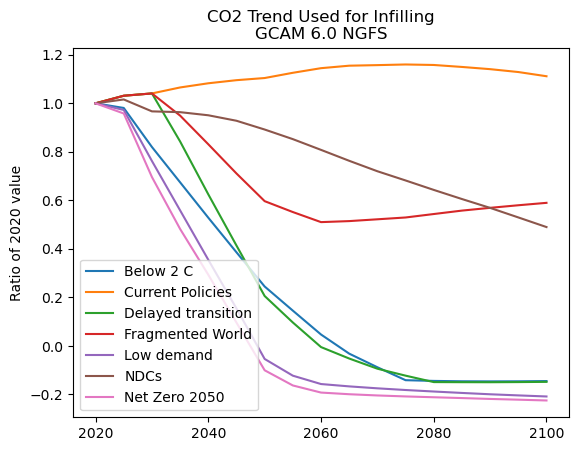

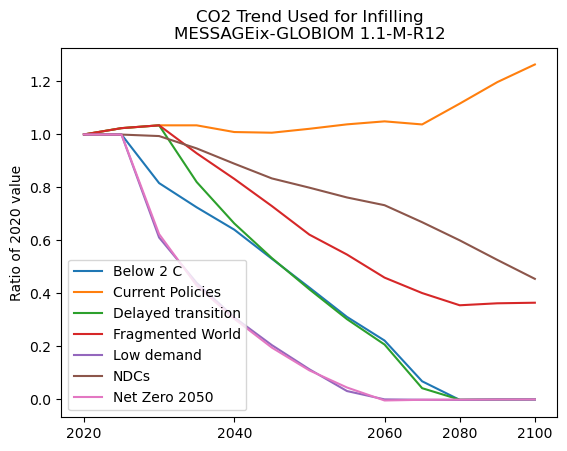

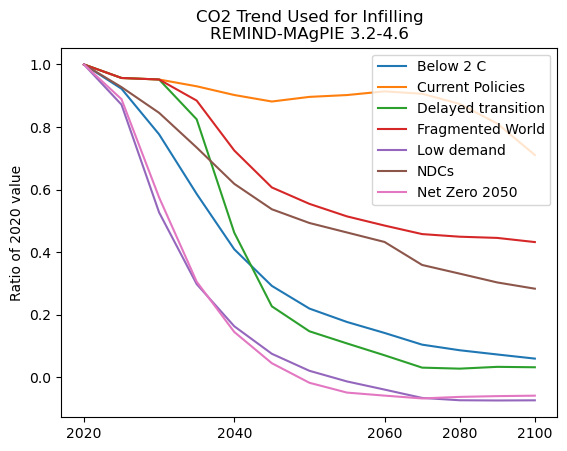

In [57]:
for df in [GCAM_trends_perc, MSG_trends_perc, REM_trends_perc]:
    plot_trend(df, 'Emissions|CO2')

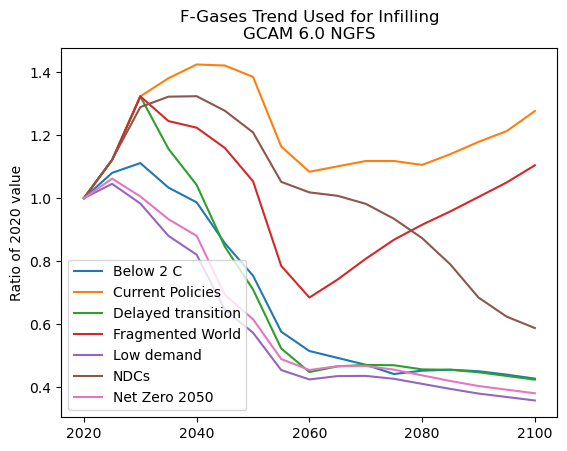

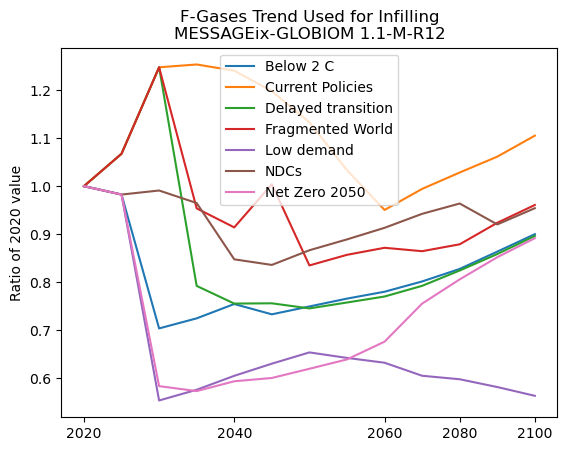

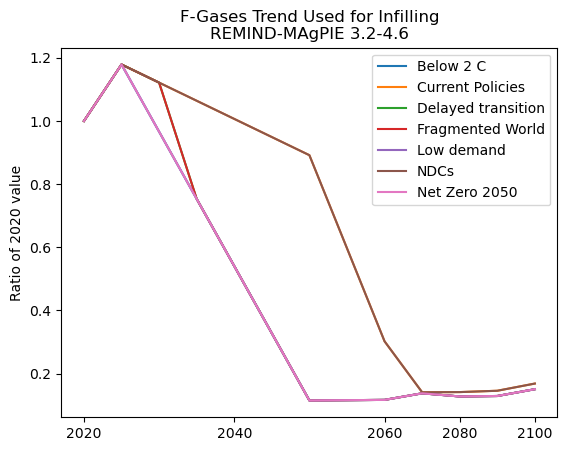

In [58]:
for df in [GCAM_trends_perc, MSG_trends_perc, REM_trends_perc]:
    plot_trend(df, 'Emissions|F-Gases')

## Interpolate & save projections

In [24]:
# all years to include in interpolated df
all_yrs = np.arange(2020, 2101)  

# years included in non-interpolated df
GCAM_yrs = np.arange(2020, 2101, 5)
MSG_yrs = [2020, 2025, 2030, 2035, 2040,
       2045, 2050, 2055, 2060, 2070, 2080, 2090, 2100] 
REM_yrs = MSG_yrs

In [25]:
def NGFS_interp(df, yrs, all_yrs):
    
    # create empty df
    df_interp = pd.DataFrame()
    df_interp[['Model', 'Scenario', 'Region', 'Variable', 'Unit']] = np.nan
    df_interp[all_yrs] = np.nan
    
    mdl = df.Model.values[0]
    reg = df.Region.values[0]
    
    # interpolate and add all values in timeseries
    for scen in df.Scenario.unique():
        for var in df.Variable.unique():
            proj = df.loc[df.Variable == var].loc[df.Scenario == scen]
            proj = proj.values[0][5:].astype(float)
            proj_interp = np.interp(all_yrs, yrs, proj)

            # create a list of the values we want to add to our new_df
            unit = df.loc[df.Variable == var].loc[df.Scenario == scen]['Unit'].values[0]
            lst = [mdl, scen, reg, var, unit] 
            for val in proj_interp.tolist():
                lst.append(val)

            # add to new_df
            df_interp.loc[len(df_interp)] = lst
            
    return df_interp

Run interpolations & save as `.csv`

In [26]:
GCAM_infilled = NGFS_interp(GCAM_infilled, GCAM_yrs, all_yrs)
MSG_infilled = NGFS_interp(MSG_infilled, MSG_yrs, all_yrs)
REM_infilled = NGFS_interp(REM_infilled, REM_yrs, all_yrs)

In [27]:
GCAM_infilled.to_csv('outputs/GCAM_cleaned.csv', index=False)
MSG_infilled.to_csv('outputs/MSG_cleaned.csv', index=False)
REM_infilled.to_csv('outputs/REM_cleaned.csv', index=False)